<img src='images/organizations-logos.png' align='center' width='100%'></img>

# Data Assimilation Practical · Joint Training in Atmospheric Composition (2021)

This practical exercise was created for the <a href ="https://atmosphere.copernicus.eu/3rd-eumetsatesaecmwf-joint-training-atmospheric-composition" target = "_blank">3rd EUMETSAT/ESA/ECMWF Joint Training in Atmospheric Composition (6-17 December, 2021)</a> to show the assimilation of NO<sub>2</sub> observations from the TROPOspheric Monitoring Instrument (TROPOMI) aboard Sentinel 5-P into the forecasts of the Copernicus Atmosphere Monitoring Service (CAMS). It is divided into the following sections:

1. [Installation](#installation): A brief guide to know how to install the <a href = "https://github.com/esowc/adc-toolbox/" target = "_blank">Atmospheric Datasets Comparison (ADC) Toolbox</a>, which contains functions that facilitate the datasets retrieval, metadata merge and statistical analysis.

2. [Datasets retrieval](#datasets_retrieval): The model and sensor datasets are downloaded and read as xarray objects before assimilating the real observations into the model dataset.

3. [Units conversion](#units_conversion): The units of both datasets are converted to molecules/cm<sup>2</sup>.

4. [Data assimilation](#data_assimilation): The model partial columns are interpolated into the TM5 grid and the averaging kernels are applied.

5. [Comparison analysis](#comparison_analysis): Statistical methods are used to better understand the differences between both datasets and the effects of the data assimilation process.

## <a id='installation'></a>1. Installation

### Clone the repository and set up the virtual environment

Participants should <a href = "https://my.wekeo.eu/web/guest/user-registration" target = "_blank">create an account in Wekeo</a> to use the JupyterHub and run this notebook. Once they <a href = "https://jupyterhub-wekeo.apps.eumetsat.dpi.wekeo.eu" target = "_blank">have access to this service</a>, they can open the terminal, or an empty Jupyter Notebook, and clone the ADC Toolbox repository with the command:

```bash
$ git clone https://github.com/esowc/adc-toolbox
```

The virtual environment <em>environment.yml</em> was generated to simplify the installation process, so you just need to create this environment from the file and activate it to install the necessary libraries and packages. Since this process might take up some time, it is better if the users simulate it by:

```bash
$ conda create --name adc-toolbox
$ conda activate adc-toolbox
$ conda install -c conda-forge/label/cartopy_dev cartopy
$ pip install -r requirements.txt
$ python -m ipykernel install --user --name adc-toolbox
```

After running the previous commands, the page should be refreshed and the correct kernel (adc-toolbox) should be selected.

To finalize the installation process, users need to create a text file under the training data folder, with the name <em>keys.txt</em>, and write down their personal CAMS API key in one line with the format <em>UID:Key</em>. This key can be obtained by <a href = "https://ads.atmosphere.copernicus.eu/user/register?">registering at the Atmosphere Data Store</a>.

### Import libraries

In [1]:
# Related to the system
import os 
from pathlib import Path

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

### Import functions

In [2]:
%run ../../functions/functions_general.ipynb
%run ../../functions/functions_cams.ipynb
%run ../../functions/functions_tropomi.ipynb

### Settings

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

## <a id='datasets_retrieval'></a>2. Datasets retrieval

### Available datasets

ADC Toolbox facilitates the data retrieval of all the datasets presented in Table 1, since the dates they became available to the public. As an exception, the retrieval of IASI L2 data is currently available only since May 14, 2019.

<p align="center"> Table 1. Temporal availability (start date - present) by data source.</p>

| Dataset | Type | NO<sub>2</sub> | O<sub>3</sub> | CO | SO<sub>2</sub> | HCHO |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| CAMS  | <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/CAMS-global-atmospheric-composition-forecasts" target = "_blank">Forecast</a> | 01.2015 | 01.2015 | 01.2015 | 01.2015 | 01.2015 | 
| CAMS  | <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/CAMS-global-ghg-reanalysis-egg4-monthly">Reanalysis</a> | 01.2003 | 01.2003 | 01.2003 | 01.2003 | 01.2003 | 
| TROPOMI  | <a href = "https://s5phub.copernicus.eu/dhus/" target = "_blank">L2</a> | 07.2018 | 07.2018 | 07.2018 | 10.2018 | - | 
| IASI  | <a href = "https://iasi.aeris-data.fr/" target = "_blank">L2</a> | - | 01.2008 | 10.2007 | 10.2007 | - |
| IASI  | <a href = "https://iasi.aeris-data.fr/" target = "_blank">L3</a> | - | 01.2008 | 10.2007 | 10.2007 | - |
| GOME-2  | <a href = "https://acsaf.org/offline_access.php" target = "_blank">L2</a> | 01.2007 | 01.2007 | - | 01.2007 | 01.2007 | 
| GOME-2  | <a href = "https://acsaf.org/offline_access.php" target = "_blank">L3</a> | 02.2007 | 01.2007 | - | 01.2007 | 01.2007 | 

Sentinel 5-P was launched in 2017 and, as it can be read in the table, the L2 products are accessible since:

* July 2018 for NO<sub>2</sub>, O<sub>3</sub> and CO concentrations.
* October 2018 for SO<sub>2</sub> concentrations.

In order to automatically download any model or sensor dataset, users only need to define:

* Name of the atmospheric component.
* Short (<em>cams</em>) and full name of the model (<em>cams-global-atmospheric-composition-forecasts</em> or <em>cams-global-reanalysis-eac4-monthly</em>).
* Short name of the sensor (<em>tropomi</em>, <em>iasi</em> or <em>gome</em>).
* Start and end date: a range will be calculated from both dates.
* Bounding box by coordinates.

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-11-21'
end_date = '2021-11-21'

# Define extent
lon_min = 12
lon_max = 15
lat_min = 49
lat_max = 51

### Comparison checker and folder generation

The toolbox will check if the merge and comparison between the specified model and sensor is possible, given the name of the species. If it is, the molecular weight and some metadata will be obtained. Afterwards, it will create the folders where the datasets will be stored.

This notebook can only be used to carry out the data assimilation process, please refer to the main code in case you wish to compare the CAMS model against the observations from IASI or GOME-2.

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


### Search period and bounding box

The search period and bounding box are derived from the details that were provided in advance.

In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-21T00:00:00Z', '2021-11-21T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 49 to 51
Longitudes: from 12 to 15


### Download and read the model data

The model dataset will be downloaded as a GRIB file and read as a xarray object. In this step, the users can decide if they want to retrieve total (<em>model_level = 'Single'</em>) or partial columns (<em>model_level = 'Multiple'</em>). In the data assimilation process, we need to obtain the partial columns and, particularly in this case, at 137 vertical levels.

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

The file exists, it will not be downloaded again.


In [8]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 6, longitude: 8, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-21
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 13.6 14.0 14.4 14.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.805e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-01T20:15 GRIB to CDM+CF via cfgrib-0.9.9...

### Download and read sensor data

The sensor dataset will be downloaded as a NetCDF file and read as a xarray object, along with its details in the attached datasets. More information about the product can be found in the <a href = "http://www.tropomi.eu/sites/default/files/files/S5P-KNMI-L2-0021-MA-Product_User_Manual_for_the_Sentinel_5_precursor_Nitrogen_dioxide-0.8.1_20151207_signed.pdf" target = "_blank">TROPOMI NO<sub>2</sub> product manual</a>.

In [9]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-21T00:00:00Z', '2021-11-21T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-01 20:15:51,020 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211121T113250_20211121T113750_21282_02_020301_20211121T124029
SELECTED
File name: a55a74f2-61e2-496a-b4ab-c38be3750212
Product name: S5P_NRTI_L2__NO2____20211121T113250_20211121T113750_21282_02_020301_20211121T124029.nc
The file exists, it will not be downloaded again.


In [10]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)

In [11]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

Within <em>support_input_ds</em> we can find the surface pressure data that we need to compute the pressure at each level, while <em>support_details_ds</em> contains the processing quality flags and air mass factors to calculate the column kernels.

In [12]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 372, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-11-21
  * scanline                               (scanline) float64 0.0 1.0 ... 371.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 16.0 ... ...
    instrument_configuration_version       (time, scanline) float32 16.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [13]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 372, time: 1)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

## <a id='units-conversion'></a>3. Units conversion

### Convert the model data units (from kg/kg to molecules/cm<sup>2</sup>)

#### Retrieve auxiliary data

The details of the 137 vertical levels in the L137 model are defined by ECMWF and are necessary to evaluate the levels pressure. From the information given, we will particularly need the coefficients <em>a</em> and <em>b</em>.


In [14]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


#### Calculate the columns above each half level (kg/kg to kg/m<sup>2</sup>)

To convert the original units (kg/kg) into molecules/cm<sup>2</sup>, we need to calculate the level pressures and the NO<sub>2</sub> columns above each CAMS half level assuming that they are 0 at the top of the atmosphere, converting the units to kg/m<sup>2</sup>.

In [15]:
# Calculate level pressures from the surface pressures
model_ds = CAMS_pressure(model_ds, model_levels_df, start_date, end_date, component_nom)

In [16]:
print('The columns above each model half level will be calculated.')

# Initialize new array
model_ds_all = []

for time in model_ds.time:

    PC_hybrid = []
    
    model_ds_time_old = model_ds.sel(time = time)

    # Initialize partial columns at the top of the atmosphere as 0
    PC_hybrid_0 = model_ds_time_old.sel(hybrid = 1)
    PC_hybrid_0['component'] = PC_hybrid_0['component'].where(PC_hybrid_0['component'] <= 0, 0, drop = False)
    PC_hybrid_0 = PC_hybrid_0.expand_dims(dim = ['hybrid'])
    PC_hybrid.append(PC_hybrid_0)
    model_ds_time_new = PC_hybrid_0

    for hybrid in range(1, 136):

        # Calculate partial columns above each model level
        PC_last = model_ds_time_new.component.sel(hybrid = hybrid)
        PC_current = model_ds_time_old.component.sel(hybrid = hybrid + 1)
        pressure_last = model_ds_time_old.pressure.sel(hybrid = hybrid)
        pressure_current = model_ds_time_old.pressure.sel(hybrid = hybrid + 1)
        pressure_diff = pressure_current - pressure_last

        # Units: (kg/kg * kg/m*s2) * s2/m -> kg/m2
        PC_above = model_ds_time_old.sel(hybrid = hybrid + 1)
        PC_above['component'] = PC_last + PC_current * pressure_diff * (1/9.81)
        PC_hybrid.append(PC_above)
        model_ds_time_new = xr.concat(PC_hybrid, pd.Index(range(1, hybrid + 2), name = 'hybrid'))

    model_ds_all.append(model_ds_time_new)

model_ds = xr.concat(model_ds_all, dim = 'time')

# Assign new units to array
units = 'kg m**-2'
model_ds['component'] = model_ds.component.assign_attrs({'units': units})
print('The model component units have been converted from kg kg**-1 to kg m**-2.')

The columns above each model half level will be calculated.
The model component units have been converted from kg kg**-1 to kg m**-2.


#### Convert units with Avogadro's number (kg/m<sup>2</sup> to molecules/cm<sup>2</sup>)

After, we convert the data units from kg/m<sup>2</sup> to molecules/cm<sup>2</sup> simply by:

In [17]:
# Get Avogadro's number
NA = 6.022*10**23
model_ds['component'] = (model_ds['component'] * NA * 1000) / (10000 * component_mol_weight)

# Assign new units to array
units = 'molec cm-2'
model_ds['component'] = model_ds.component.assign_attrs({'units': units})
print('The model component units have been converted from kg m**-2 to molec cm-2.')

The model component units have been converted from kg m**-2 to molec cm-2.


In [18]:
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 136, latitude: 6, longitude: 8, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-21
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136
  * latitude    (latitude) float64 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 13.6 14.0 14.4 14.8
    valid_time  (step) datetime64[ns] 2021-11-21 ... 2021-11-21T21:00:00
Data variables:
    component   (time, hybrid, step, latitude, longitude) float64 0.0 ... 1.9...
    pressure    (time, hybrid, step, latitude, longitude) float64 1.0 ... 9.8...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-01T20:15 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [19]:
sensor_ds['sensor_column'] = sensor_ds['sensor_column'] * 6.02214*10**19
sensor_ds['sensor_column'] = sensor_ds['sensor_column'].assign_attrs({'units': 'molec cm-2'})

print('The sensor component units have been converted from mol cm-2 to molec cm-2.')

The sensor component units have been converted from mol cm-2 to molec cm-2.


In [20]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## <a id='data_assimilation'></a>4. Data assimilation

### Calculate TM5 level pressures, column kernels and apriori profiles

In [21]:
match_table = pd.DataFrame()

print('APPLICATION OF AVERAGING KERNELS')
print('For the application of the averaging kernels, it is necessary to calculate or retrieve:')
print('1. Level pressures')
print('2. Column kernels')
print('The apriori profiles should be retrieved too, but they are not necessary.')

print('DATA AVAILABILITY')
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds = TROPOMI_column_kernel(sensor_ds, component_nom, support_details_ds)
sensor_ds = TROPOMI_apriori_profile(sensor_ds, component, support_details_ds)

sensor_ds

APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate or retrieve:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved too, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...
    pressure                                              (time, layer, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

### Subset sensor data

Subsetting the datasets will speed up the data assimilation process. CAMS dataset was already reduced to the size of the previously defined bounding box. To subset TROPOMI's dataset, we create a lookup table with the equivalent geospatial coordinates to each pair of scanline and ground pixel.

In [22]:
# Select the first date to see all the steps
time = sensor_ds.time.values[0]

# Reduce data to only one timestamp
model_ds_time = model_ds.sel(time = time)
sensor_ds_time = sensor_ds.sel(time = time)

# Subset
sensor_ds_time = TROPOMI_subset(sensor_ds_time, bbox, time, sensor, component_nom)

# Read new coordinates (after subset)
sensor_coords_df = TROPOMI_subset_lookup_table(sensor_ds_time)

In [23]:
sensor_coords_df

,ground_pixel,scanline,time,latitude,longitude,delta_time
0,108.0,136.0,2021-11-21,48.284466,12.466753,2021-11-21 11:34:39.473
1,108.0,137.0,2021-11-21,48.331722,12.439902,2021-11-21 11:34:40.313
2,108.0,138.0,2021-11-21,48.378956,12.412961,2021-11-21 11:34:41.153
3,108.0,139.0,2021-11-21,48.426193,12.385989,2021-11-21 11:34:41.993
4,108.0,140.0,2021-11-21,48.473400,12.358910,2021-11-21 11:34:42.833
...,...,...,...,...,...,...
3219,169.0,183.0,2021-11-21,51.490944,14.665862,2021-11-21 11:35:18.952
3220,169.0,184.0,2021-11-21,51.538616,14.639646,2021-11-21 11:35:19.792
3221,169.0,185.0,2021-11-21,51.586315,14.613396,2021-11-21 11:35:20.632
3222,169.0,186.0,2021-11-21,51.633984,14.587090,2021-11-21 11:35:21.472


### Transform into dataframe and change multiindex

In [24]:
# Transform data array into dataframe
match_df = sensor_ds_time.to_dataframe()

# Pass NaNs to data with qa_value under 0.5 (these values will be shown as transparent)
match_df.loc[match_df['qa_value'] <= 0.5, ['sensor_column', 'column_kernel']] = float('NaN')

# Drop levels
if component_nom == 'CO' or component_nom == 'SO2':
    
    match_df.index.names = ['corner', 'ground_pixel', 'layer', 'scanline']

elif component_nom == 'O3':

    match_df.index.names = ['corner', 'ground_pixel', 'layer', 'level', 'scanline']

# Select multiindex elements
match_df = match_df.groupby(by = ['layer', 'scanline', 'ground_pixel', 'time', 'delta_time']).mean()
match_df = match_df.reset_index(level = ['layer', 'delta_time'])
match_df = match_df.set_index('layer', append = True)

In [25]:
match_df

delta_time   latitude  \
scanline ground_pixel time       layer                                      
136.0    108.0        2021-11-21 0.0   2021-11-21 11:34:39.473  48.284466   
         109.0        2021-11-21 0.0   2021-11-21 11:34:39.473  48.304661   
         110.0        2021-11-21 0.0   2021-11-21 11:34:39.473  48.324657   
         111.0        2021-11-21 0.0   2021-11-21 11:34:39.473  48.344456   
         112.0        2021-11-21 0.0   2021-11-21 11:34:39.473  48.364063   
...                                                        ...        ...   
187.0    165.0        2021-11-21 33.0  2021-11-21 11:35:22.312  51.629597   
         166.0        2021-11-21 33.0  2021-11-21 11:35:22.312  51.642735   
         167.0        2021-11-21 33.0  2021-11-21 11:35:22.312  51.655785   
         168.0        2021-11-21 33.0  2021-11-21 11:35:22.312  51.668751   
         169.0        2021-11-21 33.0  2021-11-21 11:35:22.312  51.681629   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
136.0    108.0        2021-11-21 0.0    12.466753      0.74   3.862702e+15   
         109.0        2021-11-21 0.0    12.529378      0.74   2.187815e+15   
         110.0        2021-11-21 0.0    12.591667      0.74   5.170309e+15   
         111.0        2021-11-21 0.0    12.653625      0.74   4.146853e+15   
         112.0        2021-11-21 0.0    12.715260      0.74   6.852449e+15   
...                                           ...       ...            ...   
187.0    165.0        2021-11-21 33.0   14.348737      0.74   7.491052e+15   
         166.0        2021-11-21 33.0   14.401897      0.74   6.624323e+15   
         167.0        2021-11-21 33.0   14.454949      0.74   8.914123e+15   
         168.0        2021-11-21 33.0   14.507895      0.74   7.481983e+15   
         169.0        2021-11-21 33.0   14.560737      0.74   6.476206e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
136.0    108.0        2021-11-21 0.0                                         0.000045   
         109.0        2021-11-21 0.0                                         0.000033   
         110.0        2021-11-21 0.0                                         0.000054   
         111.0        2021-11-21 0.0                                         0.000047   
         112.0        2021-11-21 0.0                                         0.000083   
...                                                                               ...   
187.0    165.0        2021-11-21 33.0                                        0.000053   
         166.0        2021-11-21 33.0                                        0.000047   
         167.0        2021-11-21 33.0                                        0.000056   
         168.0        2021-11-21 33.0                                        0.000057   
         169.0        2021-11-21 33.0                                        0.000051   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
136.0    108.0        2021-11-21 0.0                                             0.000044      
         109.0        2021-11-21 0.0                                             0.000032      
         110.0        2021-11-21 0.0                                             0.000051      
         111.0        2021-11-21 0.0                                             0.000045      
         112.0        2021-11-21 0.0                                             0.000080      
...                                                                                   ...      
187.0    165.0        2021-11-21 33.0                                            0.000047      
         166.

### Include CAMS pressure levels into the dataframe

In [26]:
# Create index that includes CAMS pressure levels for all the locations in TROPOMI
new_array = np.concatenate([np.arange(1, 137) * 1000, sensor_ds_time.layer.values])
new_index = pd.MultiIndex.from_product([match_df.index.levels[0], 
                                        match_df.index.levels[1],
                                        match_df.index.levels[2],
                                        new_array
                                        ],
                                        names = ['scanline', 'ground_pixel', 'time', 'layer'])

# Append original and new indexes and reindex dataframe
match_df = match_df[~match_df.index.duplicated()]
match_df = match_df.reindex(match_df.index.append(new_index))

# Sort and reset index
match_df = match_df.sort_index()
match_df = match_df.reset_index()

In [27]:
match_df

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel
0,136.0,108.0,2021-11-21,0.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.100246,0.798167,1.624617,15.0,11.417969,0.995992,95538.656250,0.204045
1,136.0,108.0,2021-11-21,0.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.100246,0.798167,1.624617,15.0,11.417969,0.995992,95538.656250,0.204045
2,136.0,108.0,2021-11-21,1.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.108651,0.798167,1.624617,15.0,223.625000,0.980749,94288.828125,0.221152
3,136.0,108.0,2021-11-21,1.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.108651,0.798167,1.624617,15.0,223.625000,0.980749,94288.828125,0.221152
4,136.0,108.0,2021-11-21,2.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.157816,0.798167,1.624617,15.0,905.980469,0.950697,92088.898438,0.321224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657691,187.0,169.0,2021-11-21,132000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657692,187.0,169.0,2021-11-21,133000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657693,187.0,169.0,2021-11-21,134000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657694,187.0,169.0,2021-11-21,135000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Retrieve CAMS partial columns at TM5 grid

In [28]:
# Find latitudes in CAMS rows with scanlines and ground pixels
match_df['latitude'] = match_df.apply(lambda row: float(sensor_coords_df[
                                                       (sensor_coords_df['scanline'] == row['scanline']) & 
                                                       (sensor_coords_df['ground_pixel'] == row['ground_pixel'])]['latitude'])
                                                       if pd.isnull(row['latitude']) else row['latitude'], 
                                                       axis = 1)

In [29]:
# Find longitudes in CAMS rows with scanlines and ground pixels
match_df['longitude'] = match_df.apply(lambda row: float(sensor_coords_df[
                                                        (sensor_coords_df['scanline'] == row['scanline']) & 
                                                        (sensor_coords_df['ground_pixel'] == row['ground_pixel'])]['longitude'])
                                                        if pd.isnull(row['longitude']) else row['longitude'], 
                                                        axis = 1)

In [30]:
# Get unique timestep
sensor_times = sensor_ds_time.delta_time.isel(scanline = 0).values
model_times = model_ds_time.valid_time.values
unique_step = int(np.unique(nearest_neighbour(model_times, sensor_times)))
unique_time = model_ds_time.component.isel(step = unique_step).step.values.astype('timedelta64[h]')

# Get CAMS model partial columns above each level at closest TROPOMI locations (nearest neighbours)
match_df['model_partial_column_above'] = match_df.apply(lambda row: model_ds_time.component.sel(
                                                                    step = unique_time,
                                                                    hybrid = row['layer'] / 1000, 
                                                                    latitude = row['latitude'], 
                                                                    longitude = row['longitude'], 
                                                                    method = 'nearest').values 
                                                                    if pd.isnull(row['sensor_column']) 
                                                                    else math.nan,
                                                                    axis = 1)

In [31]:
match_df

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel,model_partial_column_above
0,136.0,108.0,2021-11-21,0.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.100246,0.798167,1.624617,15.0,11.417969,0.995992,95538.656250,0.204045,NaN
1,136.0,108.0,2021-11-21,0.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.100246,0.798167,1.624617,15.0,11.417969,0.995992,95538.656250,0.204045,NaN
2,136.0,108.0,2021-11-21,1.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.108651,0.798167,1.624617,15.0,223.625000,0.980749,94288.828125,0.221152,NaN
3,136.0,108.0,2021-11-21,1.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.108651,0.798167,1.624617,15.0,223.625000,0.980749,94288.828125,0.221152,NaN
4,136.0,108.0,2021-11-21,2.0,2021-11-21 11:34:39.473,48.284466,12.466753,0.74,3.862702e+15,0.000045,0.000044,0.157816,0.798167,1.624617,15.0,905.980469,0.950697,92088.898438,0.321224,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657691,187.0,169.0,2021-11-21,132000.0,NaT,51.681629,14.560737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6133649217569335.0
657692,187.0,169.0,2021-11-21,133000.0,NaT,51.681629,14.560737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6378103000067577.0
657693,187.0,169.0,2021-11-21,134000.0,NaT,51.681629,14.560737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6605787255719245.0
657694,187.0,169.0,2021-11-21,135000.0,NaT,51.681629,14.560737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6818586591601230.0


### Vertical interpolation of CAMS partial columns at pressure levels

In [32]:
# Get CAMS model level pressures
match_df['pressure'] = match_df.apply(lambda row: model_ds_time.pressure.sel(
                                                  step = unique_time,
                                                  hybrid = row['layer'] / 1000, 
                                                  latitude = row['latitude'], 
                                                  longitude = row['longitude'], 
                                                  method = 'nearest').values 
                                                  if pd.isnull(row['pressure']) else row['pressure'],
                                                  axis = 1)

# Transform 1D-array data to float
match_df['model_partial_column_above'] = match_df['model_partial_column_above'].apply(lambda x: float(x))
match_df['pressure'] = match_df['pressure'].apply(lambda x: float(x))

# Set multiindex again and sort for interpolation
match_df = match_df.reset_index()
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'pressure'])
match_df = match_df.sort_values(['time', 'ground_pixel','scanline', 'pressure'], 
                                ascending = [True, True, True, False])

# Interpolate partial columns onto the TM5 pressure levels.
match_df = match_df[~match_df.index.duplicated()]
match_df['model_partial_column_above'] = match_df['model_partial_column_above'].interpolate()

In [33]:
match_df

index     layer  \
time       ground_pixel scanline pressure                         
2021-11-21 108.0        136.0    95538.656250       0       0.0   
                                 95355.112344     203  136000.0   
                                 95096.352936     202  135000.0   
                                 94814.677358     201  134000.0   
                                 94508.189017     200  133000.0   
...                                               ...       ...   
           169.0        187.0    8.287472      657564    5000.0   
                                 5.747030      657563    4000.0   
                                 3.884162      657562    3000.0   
                                 2.551303      657561    2000.0   
                                 1.000182      657560    1000.0   

                                                           delta_time  \
time       ground_pixel scanline pressure                               
2021-11-21 108.0        136.0    95538.656250 2021-11-21 11:34:39.473   
                                 95355.112344                     NaT   
                                 95096.352936                     NaT   
                                 94814.677358                     NaT   
                                 94508.189017                     NaT   
...                                                               ...   
           169.0        187.0    8.287472                         NaT   
                                 5.747030                         NaT   
                                 3.884162                         NaT   
                                 2.551303                         NaT   
                                 1.000182                         NaT   

                                                latitude  longitude  qa_value  \
time       ground_pixel scanline pressure                                       
2021-11-21 108.0        136.0    95538.656250  48.284466  12.466753      0.74   
                                 95355.112344  48.284466  12.466753       NaN   
                                 95096.352936  48.284466  12.466753       NaN   
                                 94814.677358  48.284466  12.466753       NaN   
                                 94508.189017  48.284466  12.466753       NaN   
...                                                  ...        ...       ...   
           169.0        187.0    8.287472      51.681629  14.560737       NaN   
                                 5.747030      51.681629  14.560737       NaN   
                                 3.884162      51.681629  14.560737       NaN   
                                 2.551303      51.681629  14.560737       NaN   
                                 1.000182      51.681629  14.560737       NaN   

                                               sensor_column  \
time       ground_pixel scanline pressure                      
2021-11-21 108.0        136.0    95538.656250   3.862702e+15   
                                 95355.112344            NaN   
                                 95096.352936            NaN   
                                 94814.677358            NaN   
                                 94508.189017            NaN   
...                                                      ...   
           169.0        187.0    8.287472                NaN   
                                 5.747030                NaN   
                                 3.884162                NaN   
                                 2.551303                NaN   
                                 1.000182                NaN   

                                               nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline pressure                                                      
2021-11-21 108.0        136.0    95538.656250                                       0.000045   
                                 95355.112344      

In [34]:
# Drop unnecessary values
match_df = match_df.reset_index()
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'layer'])
match_df = match_df.drop(np.arange(1, 137) * 1000, level = 'layer')     

In [35]:
match_df

pressure   index  \
time       ground_pixel scanline layer                         
2021-11-21 108.0        136.0    0.0    95538.656250       0   
                                 1.0    94288.828125       2   
                                 2.0    92088.898438       4   
                                 3.0    88821.515625       6   
                                 4.0    84140.296875       8   
...                                              ...     ...   
           169.0        187.0    29.0     625.780151  657550   
                                 30.0     309.465515  657552   
                                 31.0     130.429565  657554   
                                 32.0      44.064754  657556   
                                 33.0       9.304465  657558   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-21 108.0        136.0    0.0   2021-11-21 11:34:39.473  48.284466   
                                 1.0   2021-11-21 11:34:39.473  48.284466   
                                 2.0   2021-11-21 11:34:39.473  48.284466   
                                 3.0   2021-11-21 11:34:39.473  48.284466   
                                 4.0   2021-11-21 11:34:39.473  48.284466   
...                                                        ...        ...   
           169.0        187.0    29.0  2021-11-21 11:35:22.312  51.681629   
                                 30.0  2021-11-21 11:35:22.312  51.681629   
                                 31.0  2021-11-21 11:35:22.312  51.681629   
                                 32.0  2021-11-21 11:35:22.312  51.681629   
                                 33.0  2021-11-21 11:35:22.312  51.681629   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-21 108.0        136.0    0.0    12.466753      0.74   3.862702e+15   
                                 1.0    12.466753      0.74   3.862702e+15   
                                 2.0    12.466753      0.74   3.862702e+15   
                                 3.0    12.466753      0.74   3.862702e+15   
                                 4.0    12.466753      0.74   3.862702e+15   
...                                           ...       ...            ...   
           169.0        187.0    29.0   14.560737      0.74   6.476206e+15   
                                 30.0   14.560737      0.74   6.476206e+15   
                                 31.0   14.560737      0.74   6.476206e+15   
                                 32.0   14.560737      0.74   6.476206e+15   
                                 33.0   14.560737      0.74   6.476206e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-21 108.0        136.0    0.0                                         0.000045   
                                 1.0                                         0.000045   
                                 2.0                                         0.000045   
                                 3.0                                         0.000045   
                                 4.0                                         0.000045   
...                                                                               ...   
           169.0        187.0    29.0                                        0.000051   
                                 30.0                                        0.000051   
                                 31.0                                        0.000051   
                                 32.0                                        0.000051   
                                 33.0                                        0.000051   

                                    

### Apply the averaging kernels

In [36]:
# Calculate CAMS partial columns for each TM5 layer (as difference of the interpolated values)
match_df['model_column'] =  match_df['model_partial_column_above'] - match_df['model_partial_column_above'].shift(-1)
match_df = match_df.reset_index()
match_df.loc[match_df['layer'] == 33, ['model_column']] = match_df['model_partial_column_above']
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'layer'])

# Calculate values to generate CAMS column to sum in the next step
if 'apriori_profile' in match_df.columns:
    match_df['model_column'] = match_df.apply(lambda row: row['apriori_profile'] +
                                                            row['column_kernel'] * row['model_column']  -
                                                            row['column_kernel'] * row['apriori_profile'], 
                                                            axis = 1)

else:
    match_df['model_column'] = match_df.apply(lambda row: row['model_column'] * 
                                                            row['column_kernel'], 
                                                            axis = 1)

match_df = match_df[~match_df.index.duplicated()]
match_table = match_table.append(match_df)

In [37]:
match_table

pressure   index  \
time       ground_pixel scanline layer                         
2021-11-21 108.0        136.0    0.0    95538.656250       0   
                                 1.0    94288.828125       2   
                                 2.0    92088.898438       4   
                                 3.0    88821.515625       6   
                                 4.0    84140.296875       8   
...                                              ...     ...   
           169.0        187.0    29.0     625.780151  657550   
                                 30.0     309.465515  657552   
                                 31.0     130.429565  657554   
                                 32.0      44.064754  657556   
                                 33.0       9.304465  657558   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-21 108.0        136.0    0.0   2021-11-21 11:34:39.473  48.284466   
                                 1.0   2021-11-21 11:34:39.473  48.284466   
                                 2.0   2021-11-21 11:34:39.473  48.284466   
                                 3.0   2021-11-21 11:34:39.473  48.284466   
                                 4.0   2021-11-21 11:34:39.473  48.284466   
...                                                        ...        ...   
           169.0        187.0    29.0  2021-11-21 11:35:22.312  51.681629   
                                 30.0  2021-11-21 11:35:22.312  51.681629   
                                 31.0  2021-11-21 11:35:22.312  51.681629   
                                 32.0  2021-11-21 11:35:22.312  51.681629   
                                 33.0  2021-11-21 11:35:22.312  51.681629   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-21 108.0        136.0    0.0    12.466753      0.74   3.862702e+15   
                                 1.0    12.466753      0.74   3.862702e+15   
                                 2.0    12.466753      0.74   3.862702e+15   
                                 3.0    12.466753      0.74   3.862702e+15   
                                 4.0    12.466753      0.74   3.862702e+15   
...                                           ...       ...            ...   
           169.0        187.0    29.0   14.560737      0.74   6.476206e+15   
                                 30.0   14.560737      0.74   6.476206e+15   
                                 31.0   14.560737      0.74   6.476206e+15   
                                 32.0   14.560737      0.74   6.476206e+15   
                                 33.0   14.560737      0.74   6.476206e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-21 108.0        136.0    0.0                                         0.000045   
                                 1.0                                         0.000045   
                                 2.0                                         0.000045   
                                 3.0                                         0.000045   
                                 4.0                                         0.000045   
...                                                                               ...   
           169.0        187.0    29.0                                        0.000051   
                                 30.0                                        0.000051   
                                 31.0                                        0.000051   
                                 32.0                                        0.000051   
                                 33.0                                        0.000051   

                                    

### Calculate total columns and difference between CAMS and TROPOMI datasets

In [38]:
merge_table = []

# Get data for timestep (in this training, only 1)
match_ds = match_table.query('time == @time').to_xarray()

# Read latitudes and longitudes from data array
latitude = match_ds.sel(time = time).latitude.mean(dim = 'layer')
longitude = match_ds.sel(time = time).longitude.mean(dim = 'layer')

# Get sum of CAMS data of each layer to get column data
model_final_ds_time = match_ds.sel(time = time).model_column.sum(dim = 'layer', skipna = False).astype(float)
model_final_ds_time = model_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Get mean of TROPOMI data of each layer (it must be equal)
sensor_final_ds_time = match_ds.sensor_column.sel(time = time).mean(dim = 'layer', skipna = False).astype(float)
sensor_final_ds_time = sensor_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Calculate difference
merged_ds_time = xr.merge([model_final_ds_time, sensor_final_ds_time])
merged_ds_time['difference'] = merged_ds_time.sensor_column - merged_ds_time.model_column

merge_table.append(merged_ds_time.to_dataframe())
merge_table = pd.concat(merge_table)
merge_table = merge_table.reset_index().set_index(['ground_pixel', 'scanline', 'time'])

In [39]:
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
108.0        136.0    2021-11-21  48.284466  12.466753           NaN   
             137.0    2021-11-21  48.331722  12.439902  3.176493e+15   
             138.0    2021-11-21  48.378956  12.412961  3.151821e+15   
             139.0    2021-11-21  48.426193  12.385989  3.172109e+15   
             140.0    2021-11-21  48.473400  12.358910  3.071889e+15   
...                                     ...        ...           ...   
169.0        183.0    2021-11-21  51.490944  14.665862  4.635198e+15   
             184.0    2021-11-21  51.538616  14.639646  4.412447e+15   
             185.0    2021-11-21  51.586315  14.613396  4.285906e+15   
             186.0    2021-11-21  51.633984  14.587090  4.057209e+15   
             187.0    2021-11-21  51.681629  14.560737  4.151058e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
108.0        136.0    2021-11-21   3.862702e+15           NaN  
             137.0    2021-11-21   3.869234e+15  6.927417e+14  
             138.0    2021-11-21   5.019889e+15  1.868068e+15  
             139.0    2021-11-21   4.909838e+15  1.737729e+15  
             140.0    2021-11-21   4.530779e+15  1.458890e+15  
...                                         ...           ...  
169.0        183.0    2021-11-21   8.799631e+15  4.164433e+15  
             184.0    2021-11-21   8.721514e+15  4.309067e+15  
             185.0    2021-11-21   6.471375e+15  2.185469e+15  
             186.0    2021-11-21   7.359216e+15  3.302006e+15  
             187.0    2021-11-21   6.476206e+15  2.325148e+15  

[3224 rows x 5 columns]

In [40]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,3224.000000,3224.000000,3.065000e+03,3.066000e+03,3.065000e+03
mean,50.014974,13.547760,3.262016e+15,4.920348e+15,1.658678e+15
std,0.767507,1.085933,7.781109e+14,1.939340e+15,1.714537e+15
min,48.284466,11.030529,1.433074e+15,-5.744763e+14,-3.191792e+15
25%,49.397038,12.684392,2.689813e+15,3.601369e+15,4.969118e+14
50%,50.016066,13.581194,3.114024e+15,4.762705e+15,1.634210e+15
75%,50.631640,14.426902,3.668124e+15,6.039974e+15,2.638404e+15
max,51.681629,15.845275,6.516899e+15,1.543560e+16,1.099548e+16


## <a id='comparison_analysis'></a>5. Comparison analysis

### Select plot dates

In [41]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-11-21T00:00:00.000000000']


### Select plot extent

In [42]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 49), (15, 51))


### Compare model and TROPOMI total columns

In [43]:
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
108.0        136.0    2021-11-21  48.284466  12.466753           NaN   
             137.0    2021-11-21  48.331722  12.439902  3.176493e+15   
             138.0    2021-11-21  48.378956  12.412961  3.151821e+15   
             139.0    2021-11-21  48.426193  12.385989  3.172109e+15   
             140.0    2021-11-21  48.473400  12.358910  3.071889e+15   
...                                     ...        ...           ...   
169.0        183.0    2021-11-21  51.490944  14.665862  4.635198e+15   
             184.0    2021-11-21  51.538616  14.639646  4.412447e+15   
             185.0    2021-11-21  51.586315  14.613396  4.285906e+15   
             186.0    2021-11-21  51.633984  14.587090  4.057209e+15   
             187.0    2021-11-21  51.681629  14.560737  4.151058e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
108.0        136.0    2021-11-21   3.862702e+15           NaN  
             137.0    2021-11-21   3.869234e+15  6.927417e+14  
             138.0    2021-11-21   5.019889e+15  1.868068e+15  
             139.0    2021-11-21   4.909838e+15  1.737729e+15  
             140.0    2021-11-21   4.530779e+15  1.458890e+15  
...                                         ...           ...  
169.0        183.0    2021-11-21   8.799631e+15  4.164433e+15  
             184.0    2021-11-21   8.721514e+15  4.309067e+15  
             185.0    2021-11-21   6.471375e+15  2.185469e+15  
             186.0    2021-11-21   7.359216e+15  3.302006e+15  
             187.0    2021-11-21   6.476206e+15  2.325148e+15  

[3224 rows x 5 columns]

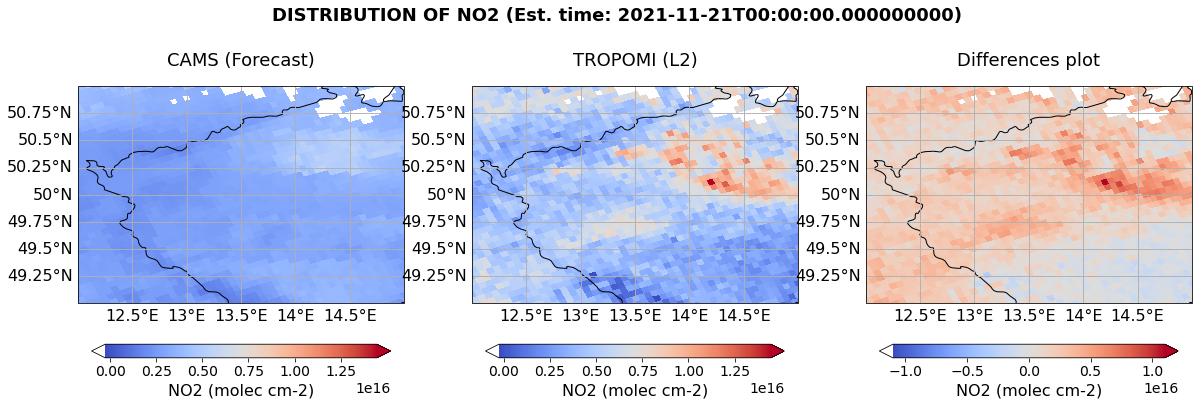

In [53]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.1, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Retrieve nearest values to specific latitude and longitude

In [45]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,ground_pixel,scanline,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,49.244698,15.845275,2021-11-21,169.0,136.0,3.268079e+15,3.149893e+15,-1.181864e+14
4,10,48.304661,12.529378,2021-11-21,109.0,136.0,3.024797e+15,2.187815e+15,-8.369829e+14
20,30,49.244698,15.845275,2021-11-21,169.0,136.0,3.268079e+15,3.149893e+15,-1.181864e+14


### Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.17 + (2.32E+15)
Coefficient of determination (R2): 0.21


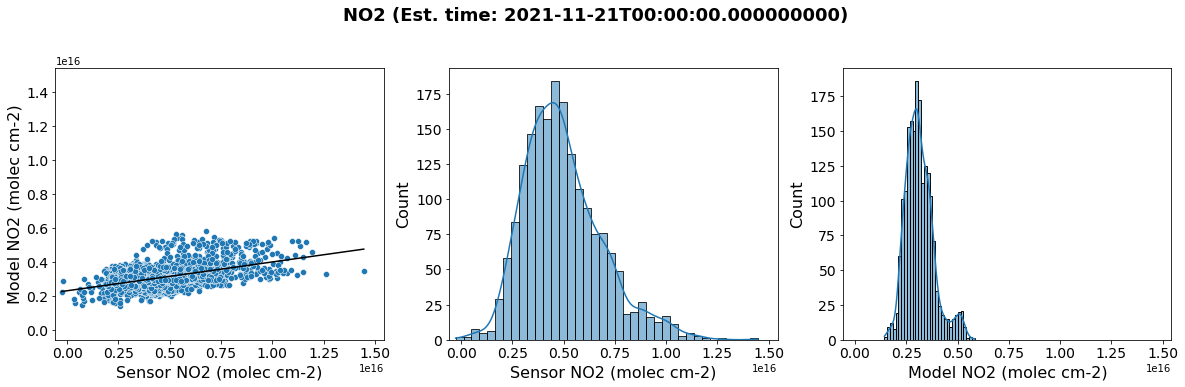

In [46]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [47]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-21,"((12, 49), (15, 51))",0.213703,0.169469,2.315756e+15


### Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.17 + (2.32E+15)
Coefficient of determination (R2): 0.21


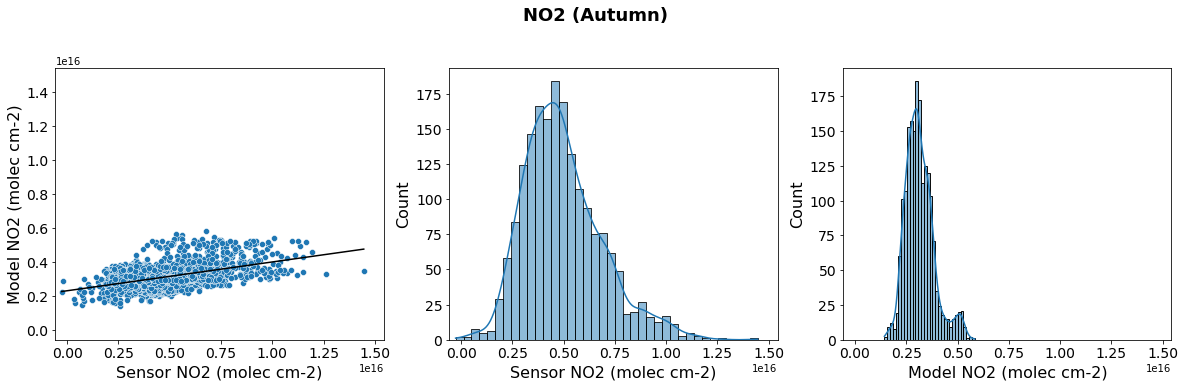

In [48]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [49]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Autumn,"((12, 49), (15, 51))",0.213703,0.169469,2.315756e+15


### Scatter plots by country (Google API required!)

In [50]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [51]:
#summary